In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
btc_data = pd.read_csv("/content/daily_btc_1.csv")

# Display the first few rows of the dataset to understand its structure
btc_data.head()

# Remove commas and convert 'Close' column to numeric
btc_data['Close'] = btc_data['Close'].str.replace(',', '').astype(float)

# Extract 'Close' prices
prices = btc_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
normalized_prices = scaler.fit_transform(prices)

# Define a function to convert data into sequences
def create_sequences(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        X.append(seq[:-1])
        y.append(seq[-1])

    return np.array(X), np.array(y)

# Create sequences with a length of 60 (approx. two months of daily data)
SEQ_LENGTH = 60
X, y = create_sequences(normalized_prices, SEQ_LENGTH)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape



((1564, 59, 1), (391, 59, 1))

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# LSTM Model
lstm_model = Sequential()

lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/10
49/49 [==============================] - 12s 107ms/step - loss: 0.0520 - val_loss: 0.0436
Epoch 2/10
49/49 [==============================] - 7s 136ms/step - loss: 0.0422 - val_loss: 0.0377
Epoch 3/10
49/49 [==============================] - 4s 86ms/step - loss: 0.0422 - val_loss: 0.0375
Epoch 4/10
49/49 [==============================] - 4s 81ms/step - loss: 0.0422 - val_loss: 0.0371
Epoch 5/10
49/49 [==============================] - 5s 101ms/step - loss: 0.0414 - val_loss: 0.0404
Epoch 6/10
49/49 [==============================] - 4s 83ms/step - loss: 0.0431 - val_loss: 0.0385
Epoch 7/10
49/49 [==============================] - 4s 82ms/step - loss: 0.0409 - val_loss: 0.0369
Epoch 8/10
49/49 [==============================] - 5s 104ms/step - loss: 0.0398 - val_loss: 0.0359
Epoch 9/10
49/49 [==============================] - 5s 96ms/step - loss: 0.0391 - val_loss: 0.0347
Epoch 10/10
49/49 [==============================] - 4s 83ms/step - loss: 0.0385 - val_loss: 0.0332


In [7]:
from tensorflow.keras.layers import GRU

# GRU Model
gru_model = Sequential()

gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(50))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
49/49 [==============================] - 12s 108ms/step - loss: 0.0537 - val_loss: 0.0406
Epoch 2/10
49/49 [==============================] - 5s 108ms/step - loss: 0.0433 - val_loss: 0.0425
Epoch 3/10
49/49 [==============================] - 5s 89ms/step - loss: 0.0407 - val_loss: 0.0328
Epoch 4/10
49/49 [==============================] - 4s 84ms/step - loss: 0.0342 - val_loss: 0.0290
Epoch 5/10
49/49 [==============================] - 6s 118ms/step - loss: 0.0311 - val_loss: 0.0256
Epoch 6/10
49/49 [==============================] - 7s 141ms/step - loss: 0.0236 - val_loss: 0.0214
Epoch 7/10
49/49 [==============================] - 7s 148ms/step - loss: 0.0201 - val_loss: 0.0190
Epoch 8/10
49/49 [==============================] - 4s 85ms/step - loss: 0.0192 - val_loss: 0.0167
Epoch 9/10
49/49 [==============================] - 6s 124ms/step - loss: 0.0183 - val_loss: 0.0156
Epoch 10/10
49/49 [==============================] - 4s 84ms/step - loss: 0.0166 - val_loss: 0.0161


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(X_train.shape[1], 1))

# Transformer block
# For self-attention, query, key, and value are the same.
query = input_layer
key = input_layer
value = input_layer

attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(query=query, key=key, value=value)
attention_output = Dropout(0.2)(attention_output)
attention_output = LayerNormalization()(attention_output + input_layer)

# Flatten and feed to a dense layer
flatten = Flatten()(attention_output)
dense_1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.2)(dense_1)
output = Dense(1)(dropout)

# Compile the model
transformer_model = Model(inputs=input_layer, outputs=output)
transformer_model.compile(optimizer='adam', loss='mean_squared_error')
transformer_model.summary()

# Training the Model
transformer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 59, 1)]              0         []                            
                                                                                                  
 multi_head_attention_1 (Mu  (None, 59, 1)                3585      ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dropout_8 (Dropout)         (None, 59, 1)                0         ['multi_head_attention_1[0][0]
                                                                    ']                      

In [10]:
#FNN MODEL
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(X_train.shape[1], 1))

# Flatten the input data
flattened_input = Flatten()(input_layer)

# First dense layer
dense_1 = Dense(128, activation='relu')(flattened_input)
dense_1 = Dropout(0.2)(dense_1)

# Second dense layer
dense_2 = Dense(64, activation='relu')(dense_1)
dense_2 = Dropout(0.2)(dense_2)

# Output layer
output = Dense(1)(dense_2)

# Create the FNN Model
fnn_model = Model(inputs=input_layer, outputs=output)
fnn_model.compile(optimizer='adam', loss='mean_squared_error')
fnn_model.summary()

# Train the FNN Model
fnn_history = fnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 59, 1)]           0         
                                                                 
 flatten_2 (Flatten)         (None, 59)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               7680      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65  

In [11]:
# Train LSTM model
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Train GRU model
gru_history = gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Train FNN model
fnn_history = fnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Train Transformer model
transformer_history = transformer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
49/49 [==============================] - 4s 83ms/step - loss: 0.0369 - val_loss: 0.0328
Epoch 2/10
49/49 [==============================] - 5s 104ms/step - loss: 0.0346 - val_loss: 0.0308
Epoch 3/10
49/49 [==============================] - 4s 82ms/step - loss: 0.0339 - val_loss: 0.0299
Epoch 4/10
49/49 [==============================] - 4s 81ms/step - loss: 0.0328 - val_loss: 0.0279
Epoch 5/10
49/49 [==============================] - 5s 104ms/step - loss: 0.0288 - val_loss: 0.0276
Epoch 6/10
49/49 [==============================] - 4s 83ms/step - loss: 0.0247 - val_loss: 0.0201
Epoch 7/10
49/49 [==============================] - 4s 83ms/step - loss: 0.0202 - val_loss: 0.0172
Epoch 8/10
49/49 [==============================] - 7s 137ms/step - loss: 0.0183 - val_loss: 0.0152
Epoch 9/10
49/49 [==============================] - 4s 91ms/step - loss: 0.0162 - val_loss: 0.0134
Epoch 10/10
49/49 [==============================] - 7s 149ms/step - loss: 0.0148 - val_loss: 0.0130
Epoch

In [14]:
# Get the base models' predictions on the test data
lstm_test_pred = lstm_model.predict(X_test)
gru_test_pred = gru_model.predict(X_test)
fnn_test_pred = fnn_model.predict(X_test)
transformer_test_pred = transformer_model.predict(X_test)

# Stack predictions together for test data
stacked_test_predictions = np.column_stack((lstm_test_pred, gru_test_pred, fnn_test_pred, transformer_test_pred))



13/13 [==============================] - 0s 23ms/step


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define and train the meta-model (Linear Regression in this case)
meta_model = LinearRegression()
meta_model.fit(stacked_train_predictions, y_train)

# Get final predictions using the Stacked Ensemble model
stacked_final_predictions = meta_model.predict(stacked_test_predictions)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, stacked_final_predictions)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, stacked_final_predictions)

# Compute R-squared (R2) score
r2 = r2_score(y_test, stacked_final_predictions)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")



Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.07
Mean Absolute Error (MAE): 0.04
R-squared (R2) Score: 0.92


Epoch 1/10
49/49 [==============================] - 1s 7ms/step - loss: 0.0375 - val_loss: 0.0065
Epoch 2/10
49/49 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 3/10
49/49 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 4/10
49/49 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 5/10
49/49 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 6/10
49/49 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 7/10
49/49 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 8/10
49/49 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 9/10
49/49 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 10/10
49/49 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0049


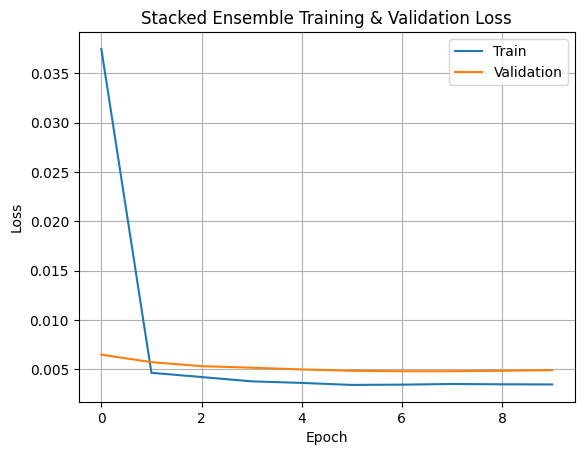

In [22]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define a simple neural network as the meta-model
meta_model = Sequential([
    Dense(32, activation='relu', input_shape=(stacked_train_predictions.shape[1],)),
    Dense(1)
])

meta_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the meta-model
stacked_history = meta_model.fit(stacked_train_predictions, y_train, epochs=10, batch_size=32, validation_data=(stacked_test_predictions, y_test))

# Plot the loss curve
import matplotlib.pyplot as plt

plt.plot(stacked_history.history['loss'], label='Train')
plt.plot(stacked_history.history['val_loss'], label='Validation')
plt.title('Stacked Ensemble Training & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

